<a href="https://colab.research.google.com/github/daeolian/Python_Example/blob/main/Simul_Response_model_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.stats import norm

Visual stimuli

In [2]:
val_bnd_screen = 10
val_bnd_stim = 8
val_resol_pix = 0.01
#
n_fr    = 24
dur_cyc = 36 # sec
dur_fr  = dur_cyc / n_fr
dur_stim_point = 3 # sec
vel_stim = val_bnd_stim / dur_cyc
#
val_wid_stim = val_bnd_stim * dur_stim_point / dur_cyc

Visualization with movie

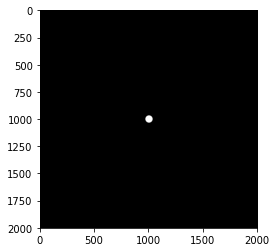

In [14]:
vec_plot_x = np.arange(start = -val_bnd_screen, stop = val_bnd_screen+val_resol_pix, step = val_resol_pix)
vec_plot_y = vec_plot_x
#
mat_mesh_x , mat_mesh_y = np.meshgrid(vec_plot_x, vec_plot_y)
#
mat_mesh_r = np.sqrt(mat_mesh_x**2 + mat_mesh_y**2)
mat_mesh_t = np.arctan2(mat_mesh_y, mat_mesh_x)
#
val_r = 0
mat_img = ( mat_mesh_r < val_r + val_wid_stim/2 ) & ( mat_mesh_r > val_r - val_wid_stim/2 )
# Set up the plot
fig, ax = plt.subplots()
im = ax.imshow(mat_img, cmap='gray')
#
def animation_function(val_r):
  mat_img = ( mat_mesh_r < val_r + val_wid_stim/2 ) & ( mat_mesh_r > val_r - val_wid_stim/2 )
  im.set_data(mat_img)
  return im

ani = FuncAnimation(fig,
						func = animation_function,
						frames = np.arange(0, 8, dur_fr*vel_stim),
						interval = dur_fr*1000) # ms
HTML(ani.to_html5_video())

Event matrix: Stimulus space

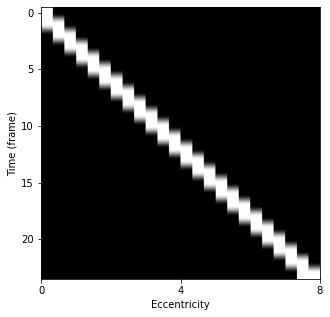

In [4]:
# Dim: Time x Space
axis_time = dur_fr *  np.arange(0,n_fr,1)
axis_spce = np.arange(0, val_bnd_stim, val_resol_pix)
n_pnt_spce = len(axis_spce)
# 
mat_stim_event = np.zeros( (len(axis_time), len(axis_spce)) )
for i_fr in range(0, n_fr):
  val_r = vel_stim * dur_fr * i_fr
  mat_stim_event[i_fr, :] = ( axis_spce < val_r + val_wid_stim/2 ) & ( axis_spce > val_r - val_wid_stim/2 )

fig, ax = plt.subplots(figsize=(5,5 ))

ax.imshow(mat_stim_event, cmap='gray')

ax.set_xlabel('Eccentricity')
ax.set_ylabel('Time (frame)');
ax.axis('auto')

ax.set_xticks([0,400,800]);
ax.set_xticklabels(['0','4','8']);


Response model

In [5]:
n_unit_resp = 4
vec_param_mu = np.linspace(0, val_bnd_stim-1, n_unit_resp)
vec_param_sig = np.ones( (n_unit_resp,1) )
#
mat_res = np.empty( (n_fr, n_unit_resp) )
mat_obs = np.empty( (n_fr, n_unit_resp) )
#
for i_unit in range(0, n_unit_resp):
  val_param_mu = vec_param_mu[i_unit]
  val_param_sig = vec_param_sig[i_unit]
  #
  vec_resp_per_spce = norm(val_param_mu, val_param_sig).pdf(axis_spce)
  #
  vec_resp_per_time = np.zeros( (n_fr,1) )
  for i_fr in range(0, n_fr):
    mat_res[i_fr,i_unit] = np.matmul(mat_stim_event[i_fr,:], vec_resp_per_spce)
  #
  mat_obs[:,[i_unit]] = mat_res[:,[i_unit]] + np.random.normal(0,1, size = (n_fr,1))

Visualization

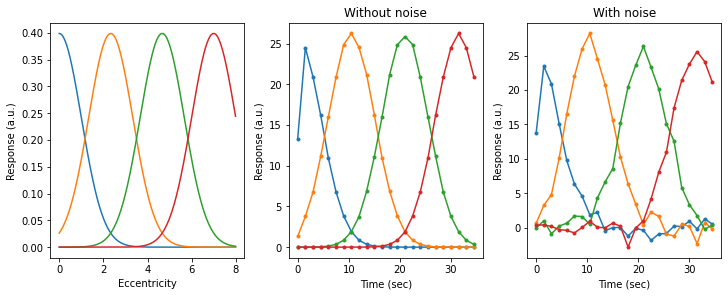

In [6]:
fig, ax = plt.subplots(1,3, constrained_layout=True)
fig.set_figwidth(10)
#
for i_unit in range(0, n_unit_resp):
  val_param_mu = vec_param_mu[i_unit]
  val_param_sig = vec_param_sig[i_unit]
  #
  vec_resp_per_spce = norm(val_param_mu, val_param_sig).pdf(axis_spce)
  #
  ax[0].plot(axis_spce, vec_resp_per_spce, '-')
  ax[0].set_xlabel('Eccentricity')
  ax[0].set_ylabel('Response (a.u.)');
  #
  vec_resp_per_time = mat_res[:,[i_unit]]
  #
  ax[1].plot(axis_time, vec_resp_per_time, '.-')
  ax[1].set_title('Without noise')
  ax[1].set_xlabel('Time (sec)')
  ax[1].set_ylabel('Response (a.u.)');
  #
  vec_resp_per_time = mat_obs[:,[i_unit]] 
  ax[2].plot(axis_time, vec_resp_per_time, '.-')
  ax[2].set_title('With noise')
  ax[2].set_xlabel('Time (sec)')
  ax[2].set_ylabel('Response (a.u.)');

Function to fit response model to observed time series

In [7]:
class model_resp:
  def __init__(self, mu_lims, sig_lims):
    self.mu_lims = mu_lims
    self.sig_lims = sig_lims
  def setdata(self, mu_lims, sig_lims):
    self.mu_lims = mu_lims
    self.sig_lims = sig_lims
  def cost_ftn(self, params, axis_spce, mat_stim_event, ts_obs):
    #
    val_mu, val_sig = params
    #
    n_fr,n_pix = mat_stim_event.shape
    vec_resp_per_spce = norm(val_mu, val_sig).pdf(axis_spce)
    #
    ts_prd = np.zeros( (n_fr,1) )
    for i_fr in range(0, n_fr):
      ts_prd[i_fr,:] = np.matmul(mat_stim_event[i_fr,:], vec_resp_per_spce)
    # Take 1-Corr rather than sse because the fitting of scale parameter is redundant 
    val_corr = np.corrcoef( ts_prd.T, ts_obs.T)[0,1]
    #
    return 1-val_corr
  def fit(self, axis_spce: np.array, mat_stim_event: np.array, ts_obs: np.array) -> 'model_resp':
    # Initial value
    val_mu = 4
    val_sig = 1
    #
    bnd_param = Bounds([ self.mu_lims[0], self.sig_lims[0]],[self.mu_lims[1], self.sig_lims[1]])
    # minimize cost function
    fit_out = minimize(self.cost_ftn, [val_mu, val_sig], args=(axis_spce, mat_stim_event, ts_obs),
                       bounds = bnd_param, tol=1e-6, options={'maxiter': 1e3}, method='Nelder-Mead' )
    fit_param = fit_out.x
    return fit_param

Fitting

In [8]:
mat_fit = np.empty( (2, n_unit_resp) )
#
fit_temp = model_resp([0, val_bnd_stim], [0.1, val_bnd_stim])
#
for i_unit in range(0, n_unit_resp):
  ts_obs = mat_obs[:,[i_unit]]
  mat_fit[:, i_unit] = fit_temp.fit(axis_spce, mat_stim_event, ts_obs)
print(mat_fit)

[[0.         2.31791564 4.68803011 6.98300289]
 [0.99573068 0.93775805 0.96957348 1.02607874]]


Visualization

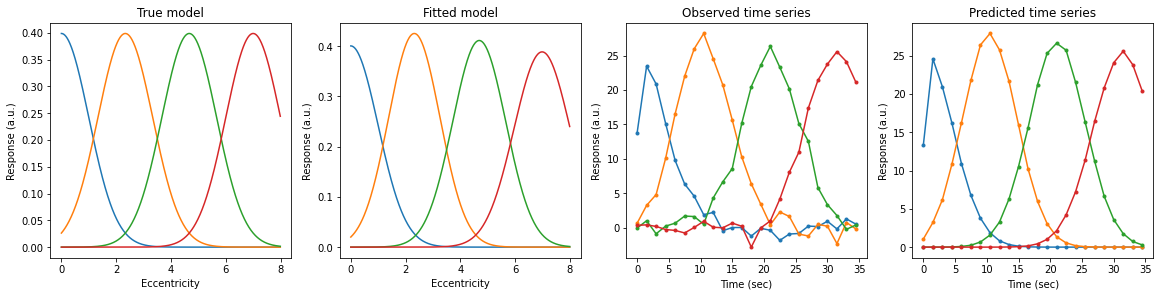

In [9]:
fig, ax = plt.subplots(1,4, constrained_layout=True)
fig.set_figwidth(16)
#
mat_res_fit_spce = np.empty( (n_unit_resp, n_pnt_spce) )
mat_res_prd = np.empty( (n_fr, n_unit_resp) )

#
for i_unit in range(0, n_unit_resp):
  val_param_mu = vec_param_mu[i_unit]
  val_param_sig = vec_param_sig[i_unit]
  #
  vec_resp_per_spce = norm(val_param_mu, val_param_sig).pdf(axis_spce)
  #
  ax[0].plot(axis_spce, vec_resp_per_spce, '-')
  ax[0].set_xlabel('Eccentricity')
  ax[0].set_ylabel('Response (a.u.)');
  ax[0].set_title('True model')
  #
  val_param_mu = mat_fit[0,i_unit]
  val_param_sig = mat_fit[1,i_unit]
  #
  vec_resp_per_spce = norm(val_param_mu, val_param_sig).pdf(axis_spce)
  mat_res_fit_spce[i_unit,:] = vec_resp_per_spce
  #
  ax[1].plot(axis_spce, vec_resp_per_spce, '-')
  ax[1].set_xlabel('Eccentricity')
  ax[1].set_ylabel('Response (a.u.)');
  ax[1].set_title('Fitted model')
  #
  vec_resp_per_time = mat_obs[:,[i_unit]] 
  ax[2].plot(axis_time, vec_resp_per_time, '.-')
  ax[2].set_title('Observed time series')
  ax[2].set_xlabel('Time (sec)')
  ax[2].set_ylabel('Response (a.u.)');
  #
  vec_resp_per_spce = norm(val_param_mu, val_param_sig).pdf(axis_spce)
  #
  vec_resp_per_time = np.zeros( (n_fr,1) )
  for i_fr in range(0, n_fr):
    mat_res_prd[i_fr,i_unit] = np.matmul(mat_stim_event[i_fr,:], vec_resp_per_spce)
  #
  vec_resp_per_time = mat_res_prd[:,[i_unit]]
  #
  ax[3].plot(axis_time, vec_resp_per_time, '.-')
  ax[3].set_title('Predicted time series')
  ax[3].set_xlabel('Time (sec)')
  ax[3].set_ylabel('Response (a.u.)');

Decoding stimulus position: based on the fitted model and observed time series

In [23]:
# Estimation based on the weighted sum of probability (likelihood)
mat_log_p = np.log(mat_res_fit_spce)
mat_ts_sum_log_p = np.matmul(mat_obs,mat_log_p)
# Take MAP from likelihood
idx_MAP = np.argmax( mat_ts_sum_log_p, axis = 1)
vec_decode_stim = axis_spce[idx_MAP]
#
np.set_printoptions(precision=2)

[0.   0.33 0.67 1.   1.33 1.67 2.   2.33 2.67 3.   3.33 3.67 4.   4.33
 4.67 5.   5.33 5.67 6.   6.33 6.67 7.   7.33 7.67]
[0.26 0.57 0.38 0.98 1.53 1.89 2.14 2.35 2.49 2.91 3.21 3.71 3.99 4.38
 4.78 5.08 5.27 5.92 6.08 6.32 6.39 7.37 6.48 6.8 ]


Visualized decoded value

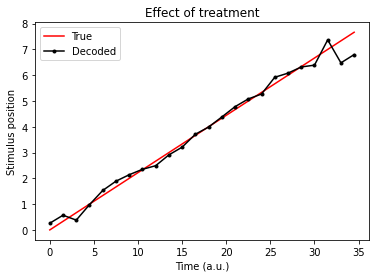

In [27]:
# Plot true model
vec_plot_x = axis_time
vec_plot_y = np.arange(0, 8, dur_fr*vel_stim)
#
plt.plot(vec_plot_x, vec_plot_y,'r-', label=f'True')
# Plot estimated value
vec_plot_x = axis_time
vec_plot_y = vec_decode_stim
#
plt.plot(vec_plot_x, vec_plot_y,'k.-', label=f'Decoded')
# Print the sample
plt.title('Effect of treatment')
plt.xlabel('Time (a.u.)')
plt.ylabel('Stimulus position')
plt.legend();

Visualize decoded stimuli

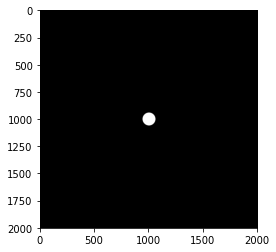

In [28]:
#
val_r = 0
mat_img = ( mat_mesh_r < val_r + val_wid_stim/2 ) & ( mat_mesh_r > val_r - val_wid_stim/2 )
# Set up the plot
fig, ax = plt.subplots()
im = ax.imshow(mat_img, cmap='gray')
#
ani = FuncAnimation(fig,
						func = animation_function,
						frames = vec_decode_stim,
						interval = dur_fr*1000) # ms
HTML(ani.to_html5_video())